# ASHRAE - Great Energy Predictor III Challenge 

![](ashrae.png)

### Importing Libraries 

In [1]:
import os 
import random
import math 
import pickle

import gc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Loading Data 

In [3]:
build_meta = pd.read_csv('building_metadata.csv')
weather_tr = pd.read_csv('weather_train.csv')
#weather_te = pd.read_csv('weather_test.csv')
train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

In [4]:
print("Number of data points in build_meta", build_meta.shape) 
print("Number of data points in weather_tr", weather_tr.shape)
#print("Number of data points in weather_te", weather_te.shape)
print("Number of data points in train_data", train_data.shape)
#print("Number of data points in test_data", test_data.shape)

Number of data points in build_meta (1449, 6)
Number of data points in weather_tr (139773, 9)
Number of data points in train_data (20216100, 4)


In [5]:
print("The attributes of building meta data :", build_meta.columns.values)

The attributes of building meta data : ['site_id' 'building_id' 'primary_use' 'square_feet' 'year_built'
 'floor_count']


In [6]:
print("The attributes of weather data :", weather_tr.columns.values)

The attributes of weather data : ['site_id' 'timestamp' 'air_temperature' 'cloud_coverage'
 'dew_temperature' 'precip_depth_1_hr' 'sea_level_pressure'
 'wind_direction' 'wind_speed']


In [7]:
print("The attributes of train data :", train_data.columns.values)

The attributes of train data : ['building_id' 'meter' 'timestamp' 'meter_reading']


#  <a id = 'section2'> 2. Data Cleaning & Preprocessing </font> </a>

#### To fit the data in our RAM  We are considering a fraction of 2000000 data points from the total training set.

In [8]:
train_data = train_data[0:2000000]

### 2.1 Removing Null values from Weather DataFrame 

For cleaning weather DataFrame we are following this notebook https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

In [9]:
weather_tr["cloud_coverage"] = (weather_tr["cloud_coverage"]).astype(np.float32)

In [10]:
weather_tr["sea_level_pressure"] = (weather_tr["sea_level_pressure"]).astype(np.float32)

In [11]:
weather_tr["precip_depth_1_hr"] = (weather_tr["precip_depth_1_hr"]).astype(np.float32)

In [12]:
weather_tr.dtypes

site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float32
dew_temperature       float64
precip_depth_1_hr     float32
sea_level_pressure    float32
wind_direction        float64
wind_speed            float64
dtype: object

In [13]:
# Full cedits to - https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

'''This function removes null values present in the weather dataframe'''

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [14]:
weather_train_df = fill_weather_dataset(weather_tr)

In [15]:
weather_train_df.isnull().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

### 2.2  Checking training dataframe for zero values 

In [16]:
train_data.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

### 2.3 Checking building dataframe for zero values 

In [17]:
build_meta.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

#### Number of zero values by percentage

In [18]:
percent_missing = build_meta.isnull().sum() * 100 / len(build_meta)
print(percent_missing)

site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64


Built year & Floor count Feature have more than 50% of missing values so we won't be using them in our modelling.

In [19]:
# Credits to - https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type

'''This function adds lags feature in the weather dataframe for given window '''

def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [20]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [21]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.0,6.000000,20.0,-0.173913,1019.700012,0.0,0.0,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.4,4.285714,21.1,-1.000000,1020.200012,70.0,1.5,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.200012,0.0,0.0,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.099976,0.0,0.0,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.000000,250.0,2.6,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [22]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag

In [23]:
weather_train_df.shape

(140544, 65)

In [24]:
weather_train_df.isnull().sum()

site_id                      0
timestamp                    0
air_temperature              0
cloud_coverage               0
dew_temperature              0
                            ..
wind_direction_std_lag72    16
wind_speed_mean_lag72        0
wind_speed_max_lag72         0
wind_speed_min_lag72         0
wind_speed_std_lag72        16
Length: 65, dtype: int64

### 2.4 Merging the DataFrames

In [25]:
# merge all the cleaned dataframes into one single dataframe
train_one = train_data.merge(right = build_meta, on = 'building_id', how = 'left')
xtr = train_one.merge(right = weather_train_df, on = ['site_id','timestamp'], how = 'left')

In [26]:
print("Number of data points in merged training set", xtr.shape)

Number of data points in merged training set (2000000, 72)


In [27]:
xtr.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
    

###  2.5 Function to reduce Memory usage by the dataframes

In [28]:
#Full credits to -
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

'''This Function reduces the size of the dataset columns by selecting samller datatypes '''

def reduce_mem_usg(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [29]:
final_xtr = reduce_mem_usg(xtr)

Mem. usage decreased to 316.62 Mb (33.1% reduction)


#### Removing long streaks of zero values from site_id 0

In [29]:
final_xtr['timestamp']=pd.to_datetime(final_xtr["timestamp"],format='%Y-%m-%d %H')

In [30]:
final_xtr['date'] = final_xtr['timestamp'].dt.date

In [31]:
final_xtr['meter_reading_log1p'] = np.log1p(final_xtr['meter_reading'])

In [32]:
#full credits to - https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type

'''This function plots the meter readings of building 0 across various months of the year'''

def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

plot_date_usage(final_xtr, meter=0, building_id=0)


Plot Summary  -  

1. From the above plot of meter reading across the year 2016 we observe a continous streak of zeros values.


2. There are continous zero values in the meter readings till May from January.


3. There are some non-zero values in the plot till May.


4. But these values too are very minute. From somewhere around mid May month we see a big jump in the meter reading. 
   Suddenly the zeros values jumps close to 130 kWh. 
   
                 
5. After this we observe a much stable meter reading compared to the previous months of January to May. 


6. From Mid-month of May till December the reading lies in the range of the 120kWh - 140kWh. 


7. Somewhere in December we see a sudden drop in the readings. The readings falls close to 100kWh for a short period of time        then it comes back in the range of 120 - 140kWh.

In [33]:
final_xtr = final_xtr.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [34]:
print("Number of data points in train set after data cleaning", final_xtr.shape)

Number of data points in train set after data cleaning (1910532, 74)


In [35]:
final_xtr[final_xtr['meter_reading'] > 40000].shape

(3629, 74)

In [36]:
final_xtr = final_xtr[final_xtr['meter_reading'] < 40000]

In [37]:
final_xtr.shape

(1906903, 74)

# <a id = 'section3'>  3. EDA </font> </a>

In [40]:
#finding the raw values of the target variable 
final_xtr.meter_reading.describe()

count    1.906903e+06
mean     4.309541e+02
std      1.560995e+03
min      0.000000e+00
25%      1.722000e+01
50%      7.326780e+01
75%      2.460000e+02
max      3.993750e+04
Name: meter_reading, dtype: float64

### 3.1 Distribution of various meter types

([<matplotlib.axis.XTick at 0x21974af14e0>,
 <a list of 4 Text xticklabel objects>)

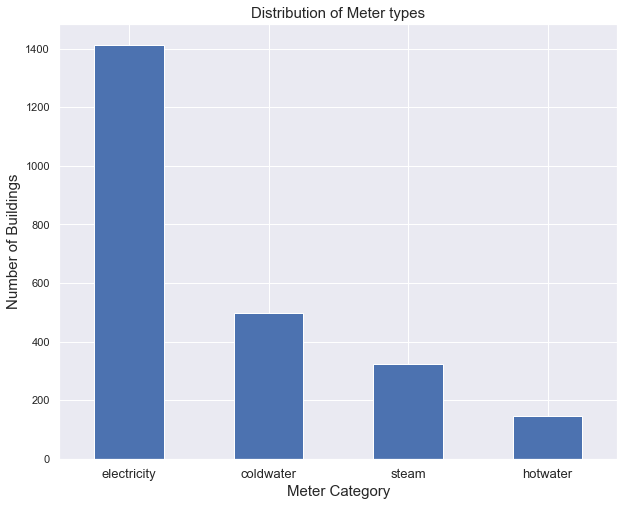

In [38]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 8))
ax = train_data.groupby('meter')['building_id'].nunique().plot(kind = 'bar')
ax.set_title('Distribution of Meter types', fontsize = 15)
plt.xlabel('Meter Category', fontsize = 15)
plt.ylabel('Number of Buildings', fontsize = 15)
plt.xticks(range(4), ["electricity", "coldwater", "steam", "hotwater"], rotation=0, fontsize=13) 

Plot Summary - 

1. The above plot shows number of meters from each category present in the number of buildings.


2. We observe that the electricity meter type is the most common meter type & is found in more than 1400 buildings.


3. Cold-water meter is found in lose to 500 buildings.


4. Steam meter type is being used in approximately 300 buildings.


5. Hot-water is the least used meter type which is found in less than 200 buildings.

### 3.2 Meter counts across various Building types

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

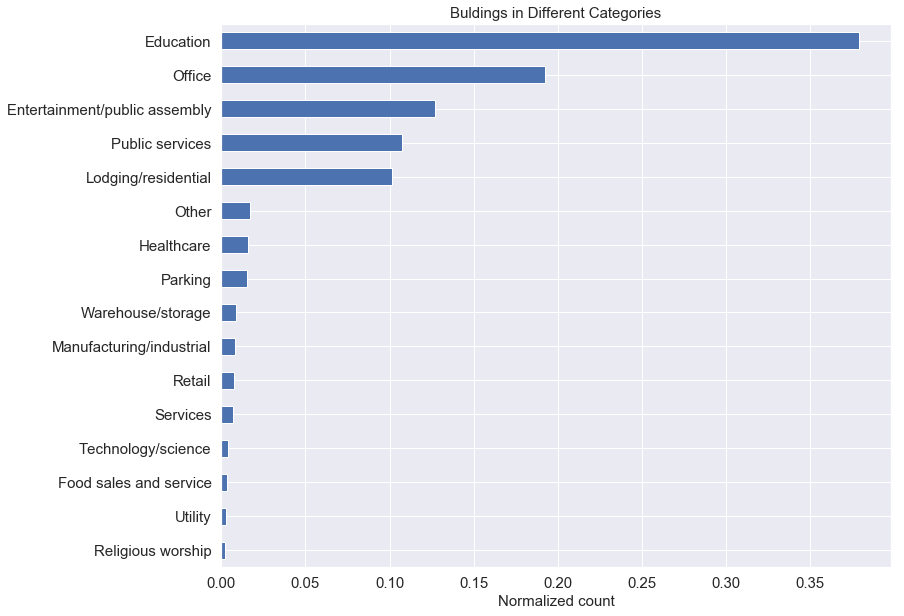

In [39]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 10))
ax = (build_meta['primary_use'].value_counts(normalize='True').sort_values(ascending=True))
ax.plot(kind = 'barh')
plt.title('Buldings in Different Categories', fontsize = 15)
plt.xlabel('Normalized count', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Plot Summary - The plot above shows the normalized count of the buldings from each category 


1. More than 35% of the buildings are under educational categories.


2. Educational category is followed by Office category being close to 20% of the total buildings.


3. Entertainment spots & public assembly places contribute 12% - 13% of the total number of the buildings.


4. Public services building account slightly more than 10% of all buildings.


5. Lodging / Residential building type covers 10% of building totality.


6. All other building categories have a much lower contribution comprising around 1 to 2 percent.


7. Least number of buildings are found under the religious worship category.

### 3.3 Meter types found in various building categories

Text(0,0.5,'Energy Usage')

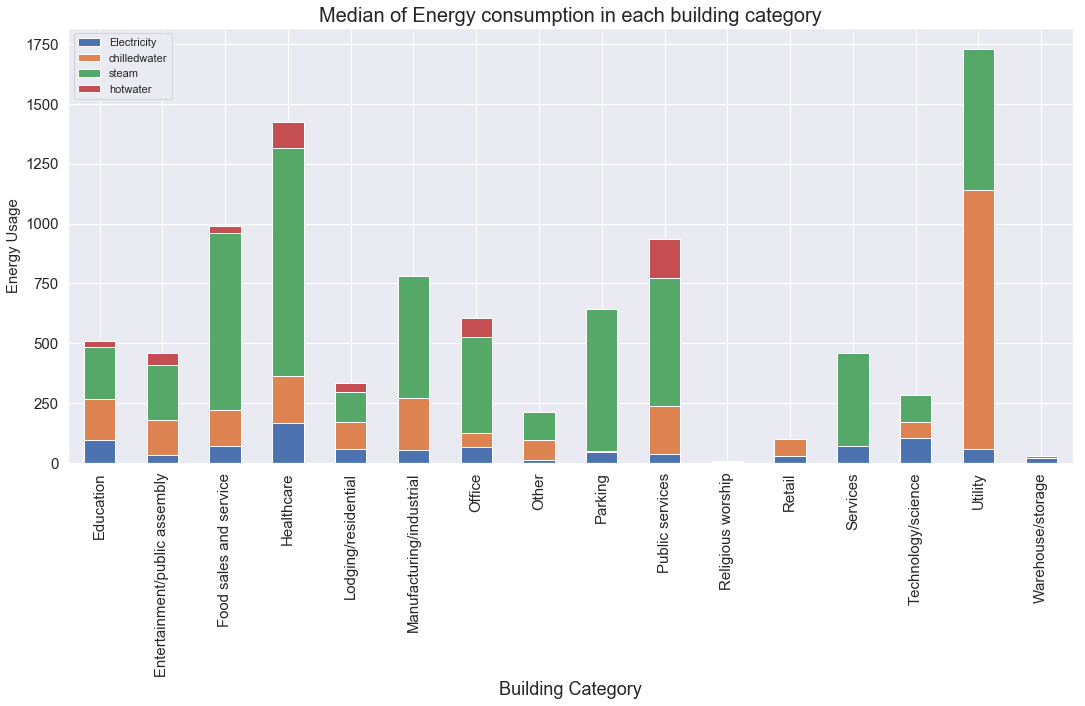

In [40]:
# reference - https://matplotlib.org/api/pyplot_api.html
ax=xtr.groupby(['primary_use', 'meter'])['meter_reading'].median().unstack().plot(stacked = True, kind = 'bar', figsize=(18,8))
ax.set_title('Median of Energy consumption in each building category', fontsize = 20)
plt.legend(labels = ['Electricity', 'chilledwater', 'steam', 'hotwater'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Building Category', fontsize = 18)
plt.ylabel('Energy Usage', fontsize = 15)

Plot Summary -  The above plot shows energy usage by different meter types in each building category 


1. From the above plot we can deduce that the electricity meter type is common in all the building categories.


2. Obviously all the building categories need electricity to run any type of device.


3. The second most common meter type is the chilled water meter type.


4. After chilled water meter type the most common meter type is the steam meter.


5. Hot water is the least found meter types.


6. Also from the plot we observe that the steam meter consumes most electricity & hence we could say its least efficient.


7. Whereas the electricity meter consumes the least energy amongst all the meter types.


8. Amongst all the building categories religious places building shows least usage whereas the utilities building have the highest usage. 


9. But chilled water meter type consumes a lot of energy in the utilities buildings.

### 3.3 Median areas of  building categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

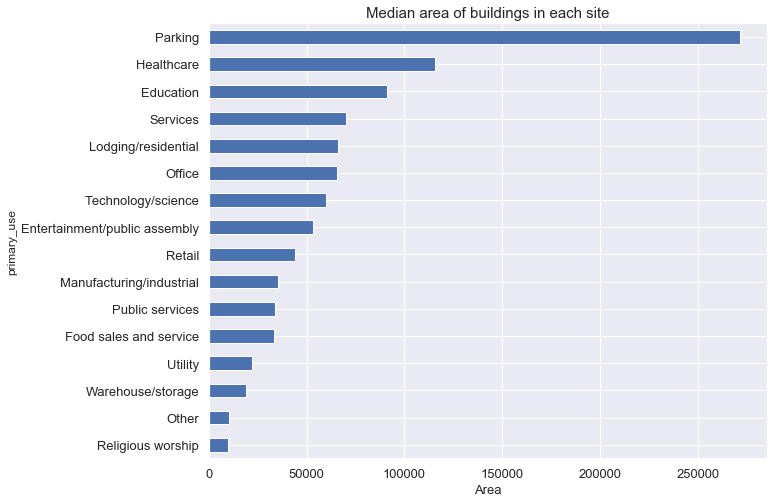

In [41]:
plt.figure(figsize=(10,8))
final_xtr.groupby('primary_use')['square_feet'].median().sort_values().plot(kind = 'barh')
plt.title('Median area of buildings in each site', fontsize = 15)
plt.xlabel('Area', fontsize = 13)
plt.xticks(fontsize=13, rotation=360)
plt.yticks(fontsize=13)

Plot Summary - The above plot shows median areas of different building categories 


1. Parking sites have the highest areas amongst all the building types which falls in the range of 250000 to 300000 square feet range.


2. This is followed by healthcare which has area slightly more than 100000 square feets.


3. Education buildings hava an area slightly less than 100000 square feets.


4. Sites of Services, lodging / residential, Office, Technology & Entertainment / Public Assembly have areas in the range of 50000 to 100000 square feets.


5. Manufacturing, Public services  & utility sites have area less than 50000 square feets.


6. Amongst all the sites religious worship places  have the least area.

### 3.3 Median Floor count of  building categories

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 9 Text yticklabel objects>)

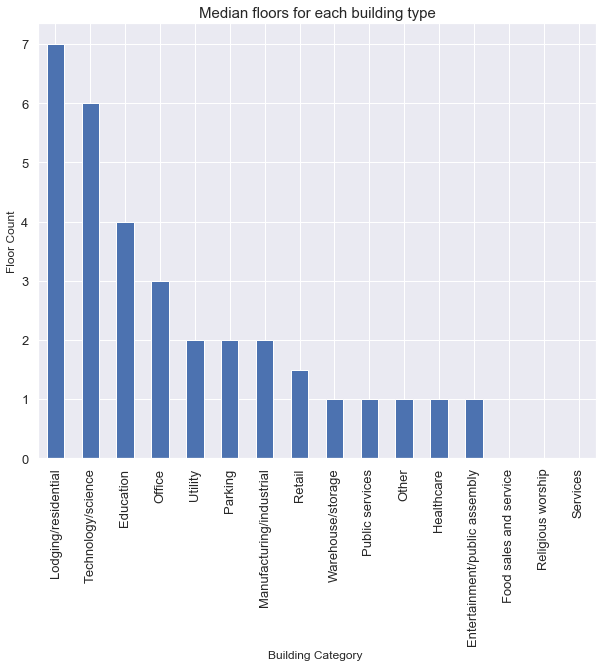

In [42]:
# Residential/Lodging are tallest
plt.figure(figsize=(10,8))
final_xtr.groupby('primary_use')['floor_count'].median().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Median floors for each building type', fontsize = 15)
plt.xlabel('Building Category ')
plt.ylabel('Floor Count')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

Plot Summary -  The above plot shows the median floor count of the buildings 


1. Residential buildings have the highest floor median count which has 7 floors.


2. Technology & science buildings has a median floor count of 6.


3. Education buildings category has median count of  4 floors.


4. Office buildings have a median floor count of 3.


5. Warehouse, Public services, Others,Healthcare, Entertainment / Public Assembly has floor median count of 1.

   
6. Food sales and services, religious worship & services have only ground floors.

### 3.4 Impact of Air Temperature on Energy Consumption

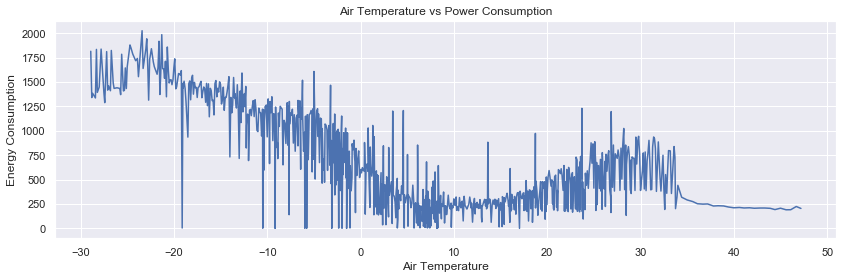

In [43]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('air_temperature')['meter_reading'].mean().plot()
ax.set_title('Air Temperature vs Power Consumption', fontsize = 12)
plt.xlabel('Air Temperature', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

Plot Summary - The above plot shows effect of energy consumption from Air temperature 


1. We observe highest energy consumption in the range of 1250 to 1750 kWh when    the air temperature range is -30 to -20 degree celsius.
   

2. From -20 to -10 degree celsius the energy consumption starts to decline &      falls in the range of 1250 to 1500 kWh.


3. We see further decrease in the energy consumption from -10 to 0 degress & it    falls in the range of 1000 kWh to 1250 kWh. 


4. The least energy consumption is seen from 10 to 20 degree celsius 0 to 250      kWh. 


5. From 20 degrees to 30 degrees the energy consumption start to rise again
   in the range of 500kWh to 750kWh.

### 3.5 Impact of Cloud coverage on Energy Consumption

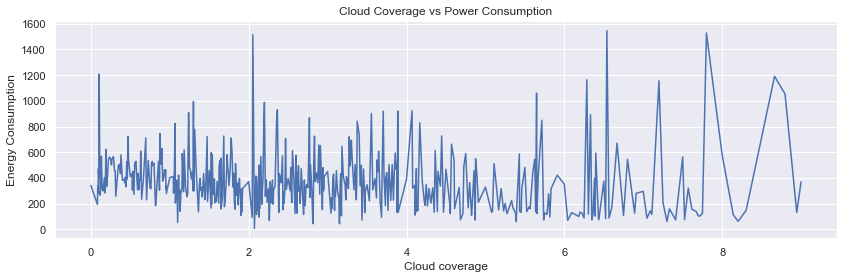

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('cloud_coverage')['meter_reading'].mean().plot()
ax.set_title('Cloud Coverage vs Power Consumption', fontsize = 12)
plt.xlabel('Cloud coverage', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

 Plot Summary - The above plot shows effect of energy consumption from cloud                   coverage 
 
 1. From the above plot we see that energy consumption remains more or less in     the same range. 
 
 
 2. From this we can conclude that the cloud coverage does not has any direct       impact on the energy consumption.
 
 
 3. We observe some higher values in the plot but it could possibly due to         present of some outlier.

### 3.5 Impact of Dew Temperature on Energy Consumption

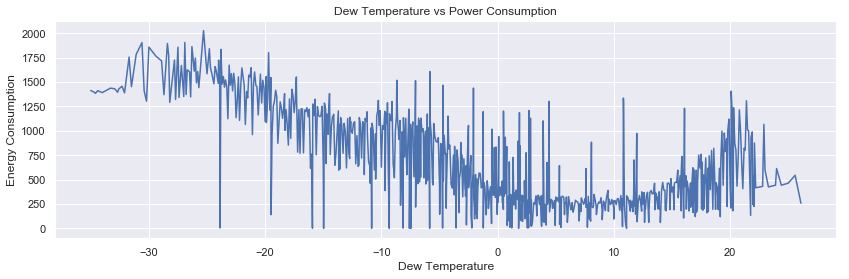

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('dew_temperature')['meter_reading'].mean().plot()
ax.set_title('Dew Temperature vs Power Consumption', fontsize = 12)
plt.xlabel('Dew Temperature', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

Plot Summary - The above plot shows effect of energy consumption from Air temperature 

1. The plot for Dew temperature vs Energy Consumption has the same pattern as the air_temperature.


2. So we can conclude that the pattern for dew temperature is same as air_temperature.


3. May be both of these features are correlated to each other & hence we are observing similar patterns in them.

### 3.6 Plotting Distribution of Target Feature

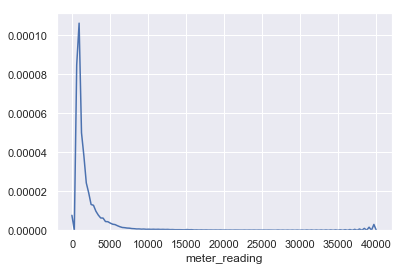

In [45]:
sns.distplot(final_xtr["meter_reading"],hist=False)

 Meter reading appears to be heavily skewed with some outliers 

#### Plotting for log normal distribution 

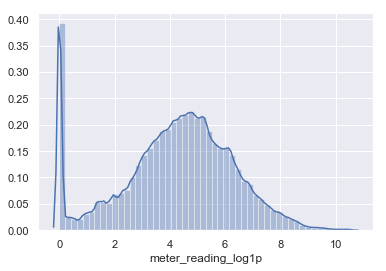

In [46]:
sns.distplot(final_xtr['meter_reading_log1p'])

 After converting to log normal distribution this plot seems much more workable now.

In [47]:
for i in range(0,100,10):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 0 percentile value of meter reading is 0.0
 The 10 percentile value of meter reading is 1.524999976158142
 The 20 percentile value of meter reading is 12.970000267028809
 The 30 percentile value of meter reading is 28.25
 The 40 percentile value of meter reading is 49.97999954223633
 The 50 percentile value of meter reading is 81.83329772949219
 The 60 percentile value of meter reading is 128.9510040283203
 The 70 percentile value of meter reading is 206.22900390625
 The 80 percentile value of meter reading is 376.6549987792969
 The 90 percentile value of meter reading is 809.780029296875
The 100 percentile value of meter reading is 39987.5


 Looks like we have some few high values near the 100th percentile.

In [48]:
for i in range(90,100):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 90 percentile value of meter reading is 809.780029296875
 The 91 percentile value of meter reading is 902.2109985351562
 The 92 percentile value of meter reading is 1007.2999877929688
 The 93 percentile value of meter reading is 1150.43994140625
 The 94 percentile value of meter reading is 1337.239990234375
 The 95 percentile value of meter reading is 1579.969970703125
 The 96 percentile value of meter reading is 1930.9200439453125
 The 97 percentile value of meter reading is 2472.199951171875
 The 98 percentile value of meter reading is 3343.070068359375
 The 99 percentile value of meter reading is 5207.7001953125
The 100 percentile value of meter reading is 39987.5


 Even going from 90th to 100 percentile the values seem reasonable till 99th percentile.

In [49]:
for i in np.arange(0.0, 1.0, 0.1):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 99.0 percentile value of meter reading is 5207.7001953125
 The 99.1 percentile value of meter reading is 5529.56005859375
 The 99.2 percentile value of meter reading is 5882.81005859375
 The 99.3 percentile value of meter reading is 6373.759765625
 The 99.4 percentile value of meter reading is 7091.33984375
 The 99.5 percentile value of meter reading is 8064.27978515625
 The 99.6 percentile value of meter reading is 9632.8095703125
 The 99.7 percentile value of meter reading is 11718.7998046875
 The 99.8 percentile value of meter reading is 14724.2001953125
 The 99.9 percentile value of meter reading is 21634.400390625
The 100 percentile value of meter reading is 39987.5


 The 99.8th percentile value to 100th percentile values seems to large & potentially could be outliers.So we will be removing these extreme values.

In [38]:
final_xtr.shape

(1906903, 74)

In [39]:
# code source - https://nbviewer.jupyter.org/github/stevensmiley1989/ASHRAE-for-ML/blob/master/Part-2-And.ipynb
final_xtr=final_xtr.drop((final_xtr.loc[final_xtr['meter_reading'] > 1.5e+04])['meter_reading'].index)

In [40]:
final_xtr.shape

(1901988, 74)

### 3.7 Steps Followed for EDA :-

1. We started with finding the range & details about the target variable likecount, mean, min value, max value etc.


2. We plotted for the distribution of meter types & found the number of buildings for each meter type.


3. Then we found the number of building in different in each catefory like educational buildings,
   offices etc.
    
    
4. Then we plotted to find which type of meter consumes what amount of electricity in each building type.


5. After this we plotted the areas of the building acccording to their primary use.


6. Then we plotted the median areas of the buildings & their floor count.


7. Then we plotted the impact of weather related features like air temperature, dew temperature,
   cloud coverage etc on the energy consumption.
    
    
8. Then we changed the distribution of target variable to log normal to reduce the skewness of the target variable.


9. Then we found the percentile values of the target variables to remove outliers from the target radings.

### 3.8 Inference from EDA

1. The electricity type meter is found in the most of the buildings followed by cold water, steam & hot water.



2. The top five buildings types with most number of meters are :- 
   i. Educational Buildings
   
   ii. Office Buildings 
   
   iii. Entertainment / Public Assembly 
   
   iv. Public Services
   
   v. Lodging / Residential 



3. The steam meter type is the most inefficient meter type as it consumes most energy comapared to other meter types.



4. After the steam type meter chilled water meter type is the least efficient meter type. Electricity meter type is the most efficient amongst all.



5. Considering all the weather related features the energy consumption is lower when the temperatures are optimal. 



6. Too low Air temperature causes very higher energy consumption.Cloud coverage does not has much impact on the energy consumption.



7. The target variable meter reading is skewed so we convert it to log normal to reduce the skewness of the data.



8. By finding the percentile values of the meter readings we further remove some outliers from the data.

### 3.9 Assumptions regarding the data

1. The target variable i.e meter reading is skewed so we took log of meter reading varaible.


2. Floor count & built year features have a vey high percentage of missing values so we are not using them for any analysis or modelling.


3. Meter readings with value of more than 40000kWh seems exceptionally large so we dropped all the datapoints which had values more than 40000kWh. 